In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

2024-10-23 22:23:20.208753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 22:23:20.218400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 22:23:20.221135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 22:23:20.228378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 22:23:20.875099: W tensorflow/compiler/tf2

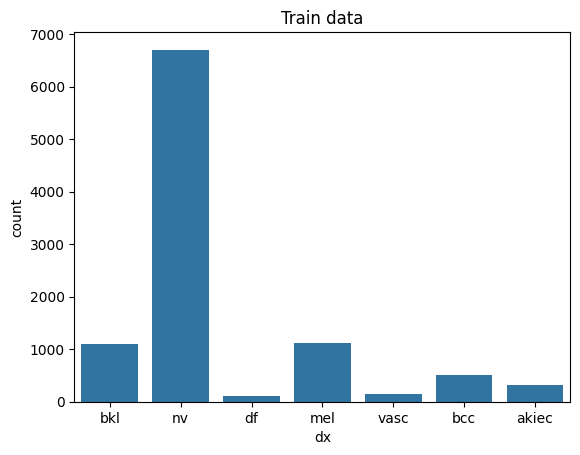

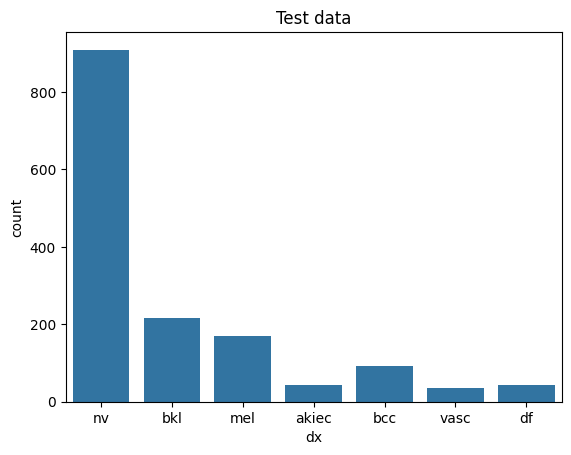

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [3]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [4]:
image_size = (128, 128)  
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9013 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


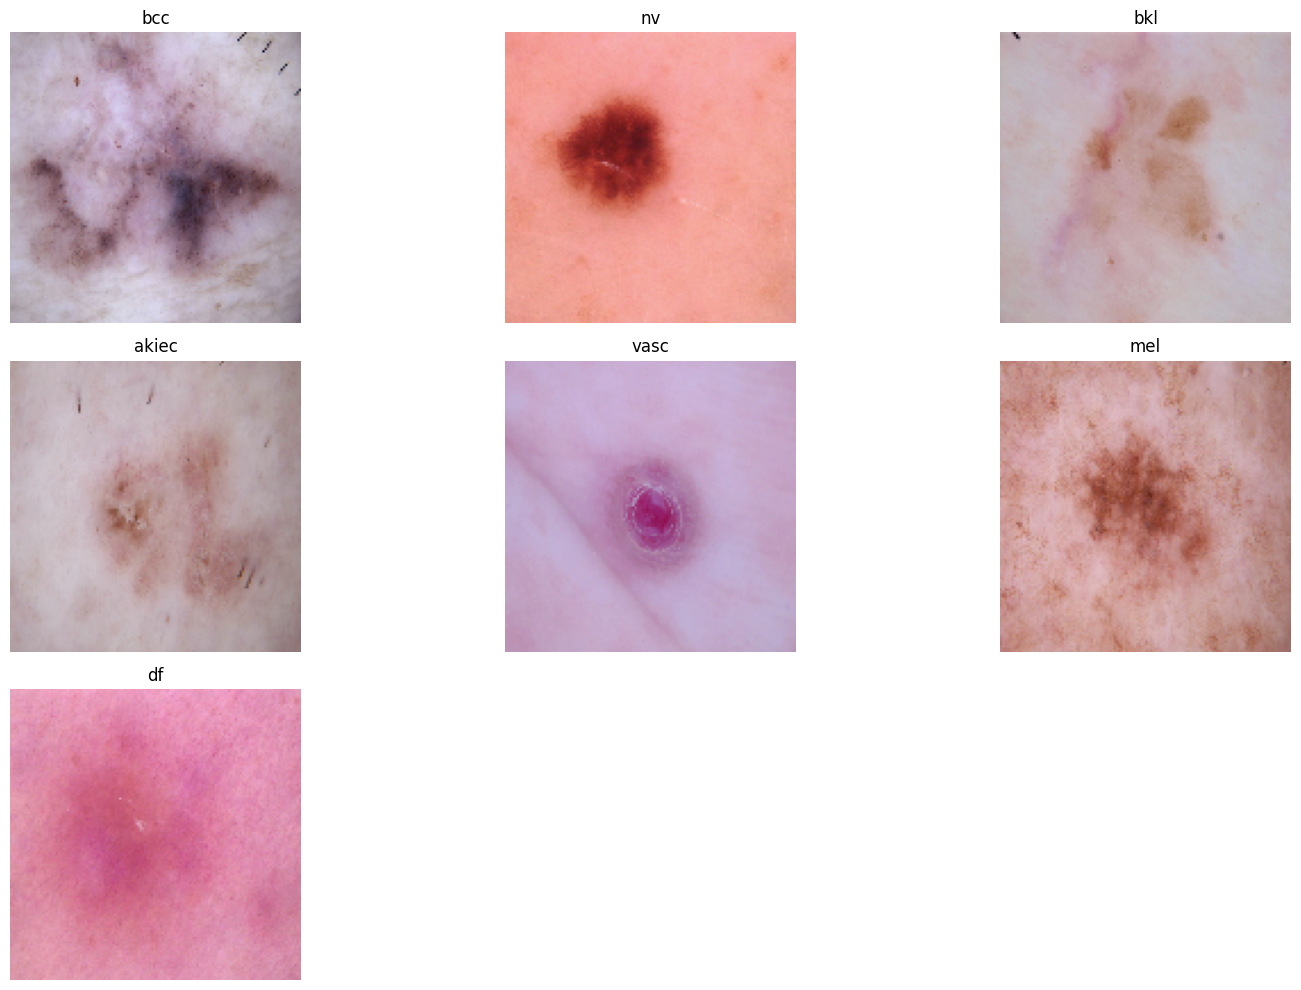

In [5]:
from tensorflow.keras.preprocessing.image import load_img

unique_classes = train_df['label'].unique()

plt.figure(figsize=(15, 10))

for i, label in enumerate(unique_classes):
    image_path = train_df[train_df['label'] == label]['image_path'].values[0]
    
    img = load_img(image_path, target_size=image_size)
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label_encoder.inverse_transform([int(label)])[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
def create_cnn_model(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()

    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # To reduce overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Assuming multi-class classification

    return model

# Initialize the model
input_shape = (128, 128, 3)
num_classes = len(df['label'].unique())  # Number of unique labels
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()


/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729715002.171061    8213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729715002.191103    8213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729715002.191182    8213 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729715002.193139    8213 cuda_e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,687 (3.43 MB)

 Trainable params: 899,687 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,    
    )


/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1729715005.422711    8290 service.cc:146] XLA service 0x7fd3a4005250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729715005.422739    8290 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-23 22:23:25.443338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 22:23:25.554484: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/71 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.1934 - loss: 1.9098  

I0000 00:00:1729715014.727643    8290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 727ms/step - accuracy: 0.6270 - loss: 1.2169 - val_accuracy: 0.6697 - val_loss: 1.0072
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 618ms/step - accuracy: 0.6649 - loss: 1.0511 - val_accuracy: 0.6697 - val_loss: 0.9816
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 616ms/step - accuracy: 0.6685 - loss: 0.9875 - val_accuracy: 0.6697 - val_loss: 0.9022
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 628ms/step - accuracy: 0.6695 - loss: 0.9524 - val_accuracy: 0.6697 - val_loss: 0.9034
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - accuracy: 0.6661 - loss: 0.9155 - val_accuracy: 0.6717 - val_loss: 0.8871
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 607ms/step - accuracy: 0.6743 - loss: 0.8888 - val_accuracy: 0.6786 - val_loss: 0.8724
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step - accuracy: 0.6734 - loss: 0.8692 - val_accuracy: 0.6707 - val_loss: 0.8643
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 611ms/step - accuracy: 0.6716 - loss: 0.8608 - val_accuracy: 0.679

In [41]:
model.save('models/accuracy065_auc_050.keras')

In [8]:
from sklearn.metrics import roc_auc_score, f1_score

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.6846 - loss: 0.8861
Test Accuracy: 0.6578425168991089


In [34]:
y_score = model.predict(test_generator)
y_score

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step


array([[1.6769861e-01, 1.0942348e-01, 3.7454379e-01, ..., 3.9611712e-02,
        2.3644152e-01, 4.0739477e-03],
       [7.8576272e-03, 4.5206398e-03, 4.0337197e-02, ..., 1.7082255e-03,
        9.3909240e-01, 1.8478840e-04],
       [4.3860466e-05, 8.8416726e-07, 5.7387613e-03, ..., 4.3269661e-03,
        9.8988920e-01, 5.2742372e-08],
       ...,
       [1.1726232e-05, 1.7794986e-07, 1.0171210e-03, ..., 4.0466807e-04,
        9.9856609e-01, 4.9717963e-09],
       [3.7770156e-02, 6.0943082e-02, 2.9513586e-01, ..., 1.6040051e-01,
        4.2778516e-01, 5.1928358e-04],
       [2.6380070e-02, 1.0016346e-01, 2.1288037e-01, ..., 4.8278466e-02,
        5.9631443e-01, 1.8466635e-03]], dtype=float32)

In [35]:
baseline_ovo_auc = roc_auc_score(test_generator.classes, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(test_generator.classes, y_score, multi_class="ovr")

print(f'Baseline model OVO AUC: {baseline_ovo_auc}')
print(f'Baseline model OVR AUC: {baseline_ovr_auc}')

Baseline model OVO AUC: 0.5056553287738174
Baseline model OVR AUC: 0.5163224456594442


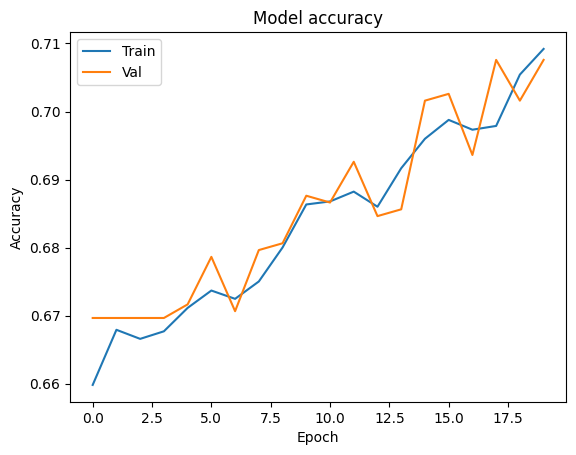

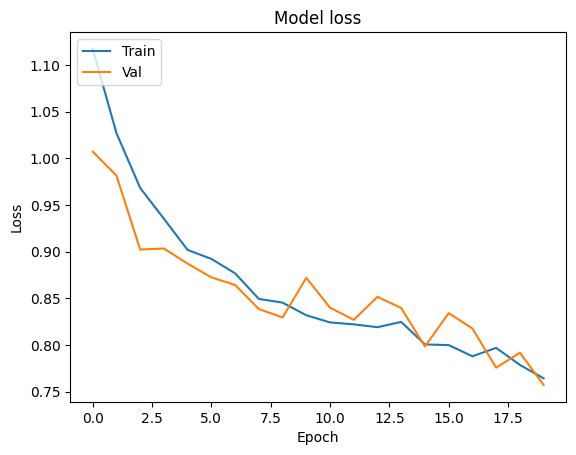

In [36]:
# visualize the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# visualize the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

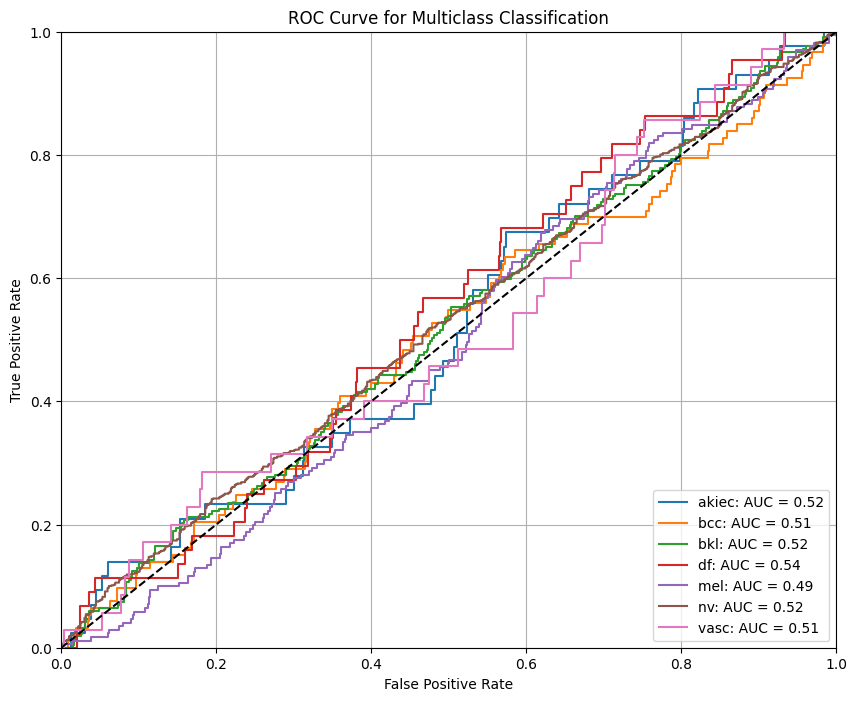

In [39]:
y_true = test_generator.classes  # true labels
y_true = to_categorical(y_true, num_classes)  # One-hot encode the true labels

class_names = label_encoder.inverse_transform(np.arange(num_classes))  # Get original class names

from sklearn.metrics import roc_curve, auc

# Prepare for plotting ROC curves
num_classes = y_true.shape[1]  # number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))

# Plotting the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')  # Use class names
# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for chance level
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()
